### Определение автомобилей с механикой и вариатором
##### Так как нужно не просто разбить заезды по группам, а определить какой заезд был совершен на каком автомобиле, то чтобы компенсировать отсутствие разметки, придется немного погрузиться в теорию и сделать предположение.
##### 1. Разница между механикой и вариатором в том, что на механике происходят скачик в оборотах при переключении передачи, а в вариаторе в принципе нет передач и последовательность замеров оборотов должна быть более гладкой (но все равно без линейной зависимости от скорости).
##### 2. Исходя из первого пункта, можно сделать предположение о том, что разница между механикой и вариатором лучше всего видна при наборе скорости автомобилем с места (или наоборот).
##### 3. После группировки данных по заездом типа старт с места с набором скорости и несколькими визуализациями уже можно на многих примерах отличить механику - резкие скачки оборотов в районе 20 и 40 км/ч. Так как на 20км/ч данных меньше и больше выбросов, то можно остановиться на скачках около 40км/ч.
##### 4. Для каждого заезда выделим подгруппу заездов, в которых скорость от 30 до 50 км/ч (передачи не всегда переключаются именно в 40), и в которых в период от 5 предыдущих до 5 следующих замеров идет набор скорости. Теперь можно построить гистограмму с изменением оборотов для таких подгрупп по каждому заезду. Исходя из предыдущих пунктов, более равномерные распределения будут говорить о высокой вероятности заезда на автомобиле с вариатором, менее равномерные распределения и распределения с выбросами на больших оборотах, наоборот, будут говорить о вероятности заезда на механике.
##### 5. Взяв за векторное представление заезда значения в нодах гистограммы из предыдущего пункта, можно кластеризовать заезды, визуализировать кластеры и определить какой кластер относится к механике, а какой к вариатору.

### Импорт бибилиотек, загрузка данных и простая предобработка

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter, defaultdict
from random import sample
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('Transmission.csv', encoding='utf-8')

df['deacceleration'] = df['deacceleration'] * -1
columns=['rpm', 'acceleration', 'deacceleration', 'speed']
for column in columns:
    df[column+'_processed'] = df[column] / df[column].max()

track_id_stop_list = [x for x, y in Counter(df['trackid']).items() if y == 5]

In [3]:
df['prev speed'] = df['speed'].shift(1)
df['next speed'] = df['speed'].shift(-1)

df['prev1 speed'] = df['speed'].shift(2)
df['next1 speed'] = df['speed'].shift(-2)

df['prev2 speed'] = df['speed'].shift(3)
df['next2 speed'] = df['speed'].shift(-3)

df['prev3 speed'] = df['speed'].shift(4)
df['next3 speed'] = df['speed'].shift(-4)

df['prev4 speed'] = df['speed'].shift(5)
df['next4 speed'] = df['speed'].shift(-5)

df['prev5 speed'] = df['speed'].shift(6)
df['next5 speed'] = df['speed'].shift(-6)

df['prev6 speed'] = df['speed'].shift(7)
df['next6 speed'] = df['speed'].shift(-7)

df['prev7 speed'] = df['speed'].shift(8)
df['next7 speed'] = df['speed'].shift(-8)

df['prev8 speed'] = df['speed'].shift(9)
df['next8 speed'] = df['speed'].shift(-9)

df['start'] = np.where((df['speed'] == 0) & (df['next speed'] > 0), 1, 0)
df['stop'] = np.where((df['speed'] == 0) & (df['prev speed'] > 0), 1, 0)
df['sleep'] = np.where((df['speed'] == 0) &
                       (df['prev speed'] == 0) &
                       (df['next speed'] == 0), 1, 0)
df['std5'] = df[['prev1 speed', 'prev speed',
                 'speed', 'next speed',
                 'next1 speed']].apply(lambda x: pd.Series(x).std(), axis=1)

def find_extr_max(X):
    x = X[9]
    before = list(X[:10])
    after = list(X[9:])
    if max(before) == max(after) == x and x != min(after) and x != min(before):
        return 1
    return 0

def find_extr_min(X):
    x = X[9]
    before = list(X[:10])
    after = list(X[9:])
    if min(before) == min(after) == x and x != max(after) and x != max(before):
        return 1
    return 0

extr_cols = ['prev8 speed', 'prev7 speed', 'prev6 speed', 'prev5 speed',
             'prev4 speed', 'prev3 speed', 'prev2 speed', 'prev1 speed', 'prev speed',
             'speed',
             'next speed', 'next1 speed', 'next2 speed', 'next3 speed', 'next4 speed',
             'next5 speed', 'next6 speed', 'next7 speed', 'next8 speed']

df['if_extr_max'] = df[extr_cols].apply(lambda x: find_extr_max(x), axis=1)

df['if_extr_min'] = df[extr_cols].apply(lambda x: find_extr_min(x), axis=1)

df['prev rpm'] = df['rpm'].shift(1)
df['next rpm'] = df['rpm'].shift(-1)

df['diff_rpm'] = df[['prev rpm', 'rpm']].apply(lambda x: abs(x[1]-x[0]),
                                               axis=1)

### Функция для визуализации подгрупп заездов

In [87]:
def get_random_start_draw(subtracks, track_id=None, sten=[]):
    track_id = sample(list(subtracks.keys()), 1)[0] if not track_id else track_id
    st, en = sample(subtracks[track_id], 1)[0] if not sten else sten

    fig, axs = plt.subplots(3, 1, figsize=(25,25))
    fig.suptitle(f'{track_id} {st} {en}', fontsize=25)

    X = range(en-st+1)
    Yrpm = df[st:en+1]['rpm_processed'].values
    axs[0].scatter(X, Yrpm, c='blue')

    Yspeed = df[st:en+1]['speed_processed'].values
    axs[0].scatter(X, Yspeed, c='red')

    Yacc = df[st:en+1]['acceleration_processed'].values
    axs[0].scatter(X, Yacc, c='orange')

    Ydea = df[st:en+1]['deacceleration_processed'].values
    axs[0].scatter(X, Ydea, c='green')

    Yrpm = df[st:en+1]['rpm'].values
    axs[1].scatter(X, Yrpm, c='blue')

    Yspeed = df[st:en+1]['speed'].values
    axs[2].scatter(X, Yspeed, c='red')

    plt.show()

### Выделение нужных подгрупп

In [107]:
subtracks = defaultdict(list)

for track_id in df['trackid'].unique():
    start = df[df['trackid'] == track_id].index[0]

    for i in df[df['trackid'] == track_id].index:
        flag = False

        if df.loc[i, 'stop'] == 1:
            subtracks[track_id].append([start, i])
            flag = True
        if df.loc[i, 'start'] == 1:
            flag = True
            start = i

        if df.loc[i, 'if_extr_min'] == 1 and df.loc[i, 'std5'] >= 2:
            if not flag:
                if df.loc[start, 'speed'] <= 10:
                    subtracks[track_id].append([start, i])
                start = i

In [110]:
subtracksZtH = defaultdict(list)

for key, vals in subtracks.items():
    for val in vals:
        data = df[val[0]:val[1]+1][['rpm', 'speed',
                                    'acceleration',
                                    'deacceleration']].reset_index(drop=True)
        if data.loc[0, 'speed'] == 0 and data['speed'].max() >= 50:
            st = val[0]
            en = data[data['speed'] >= 50].index[0] + st
            subtracksZtH[key].append([st, en])

### Визуализация двух примеров - первый больше похож на вариатор, второй - на механику
##### Три графика для каждой визуализации, на первом вместе отображены все переменные:
##### синий - обороты, красный - скорость, оранжевый - ускорение, зеленый - замедление
##### на втором и третьем графике отдельно выведены обороты и скорость (для того, чтобы увидеть абсолютные значения на шкале слева)

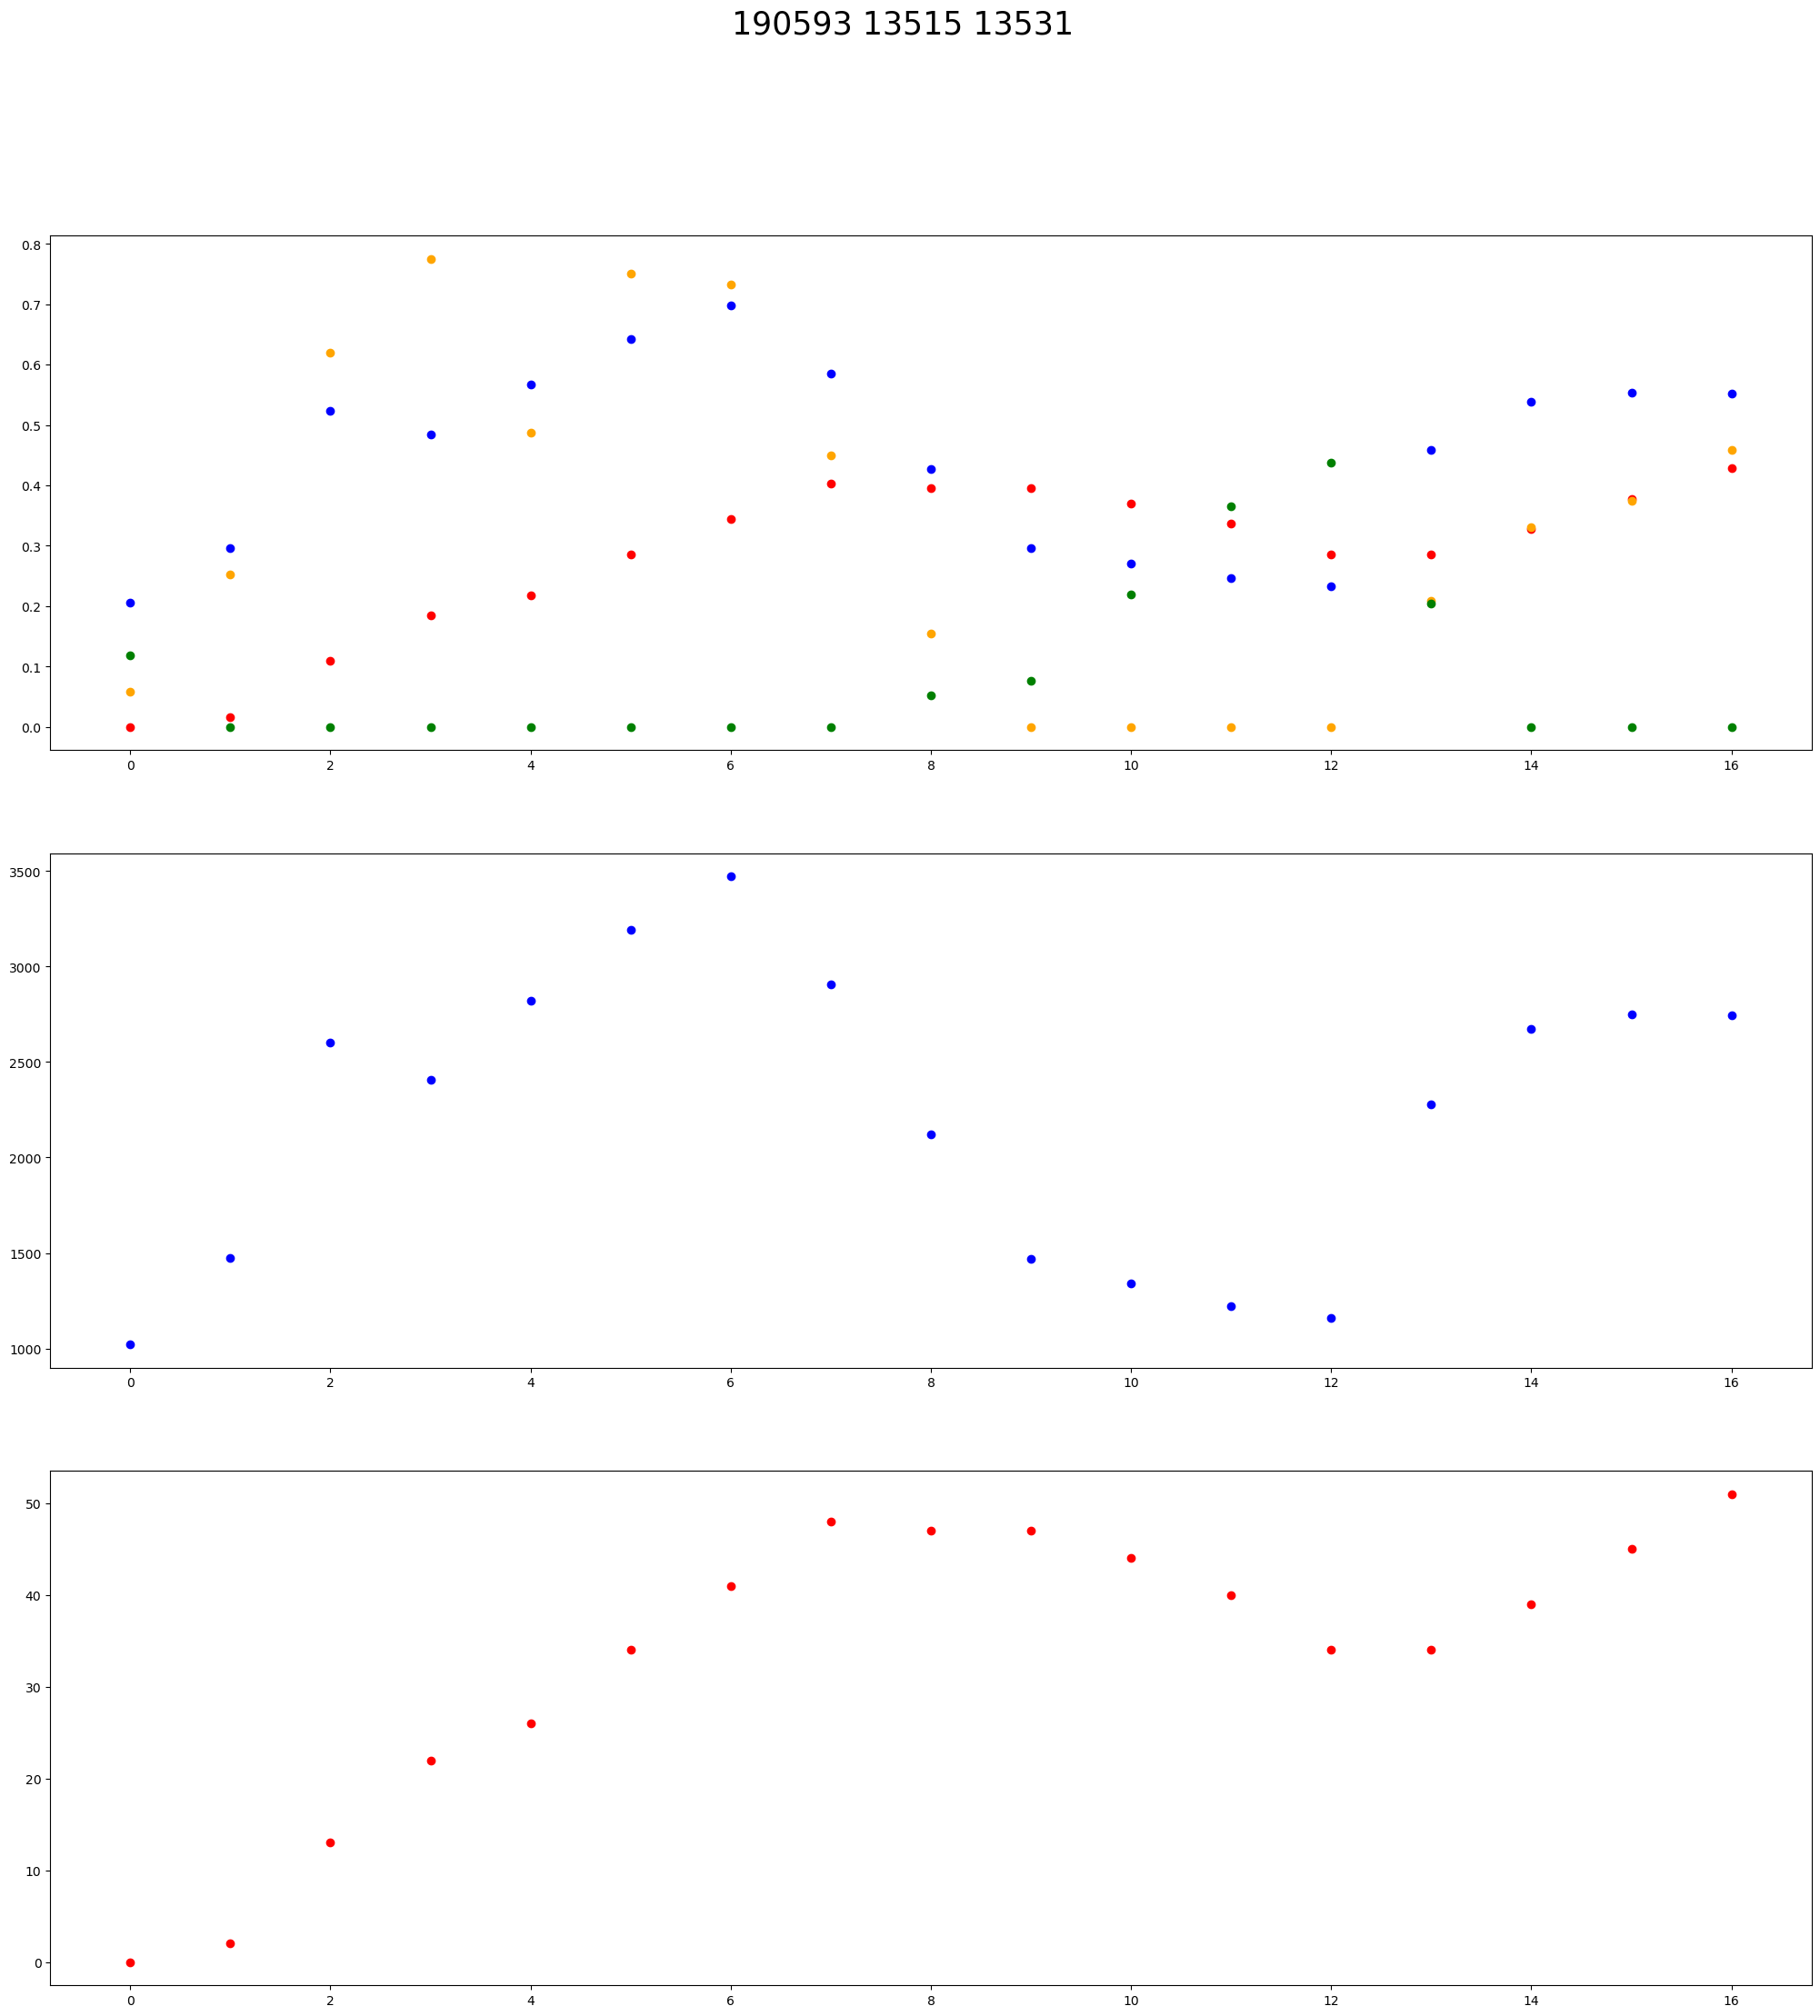

In [145]:
get_random_start_draw(subtracks=subtracksZtH)

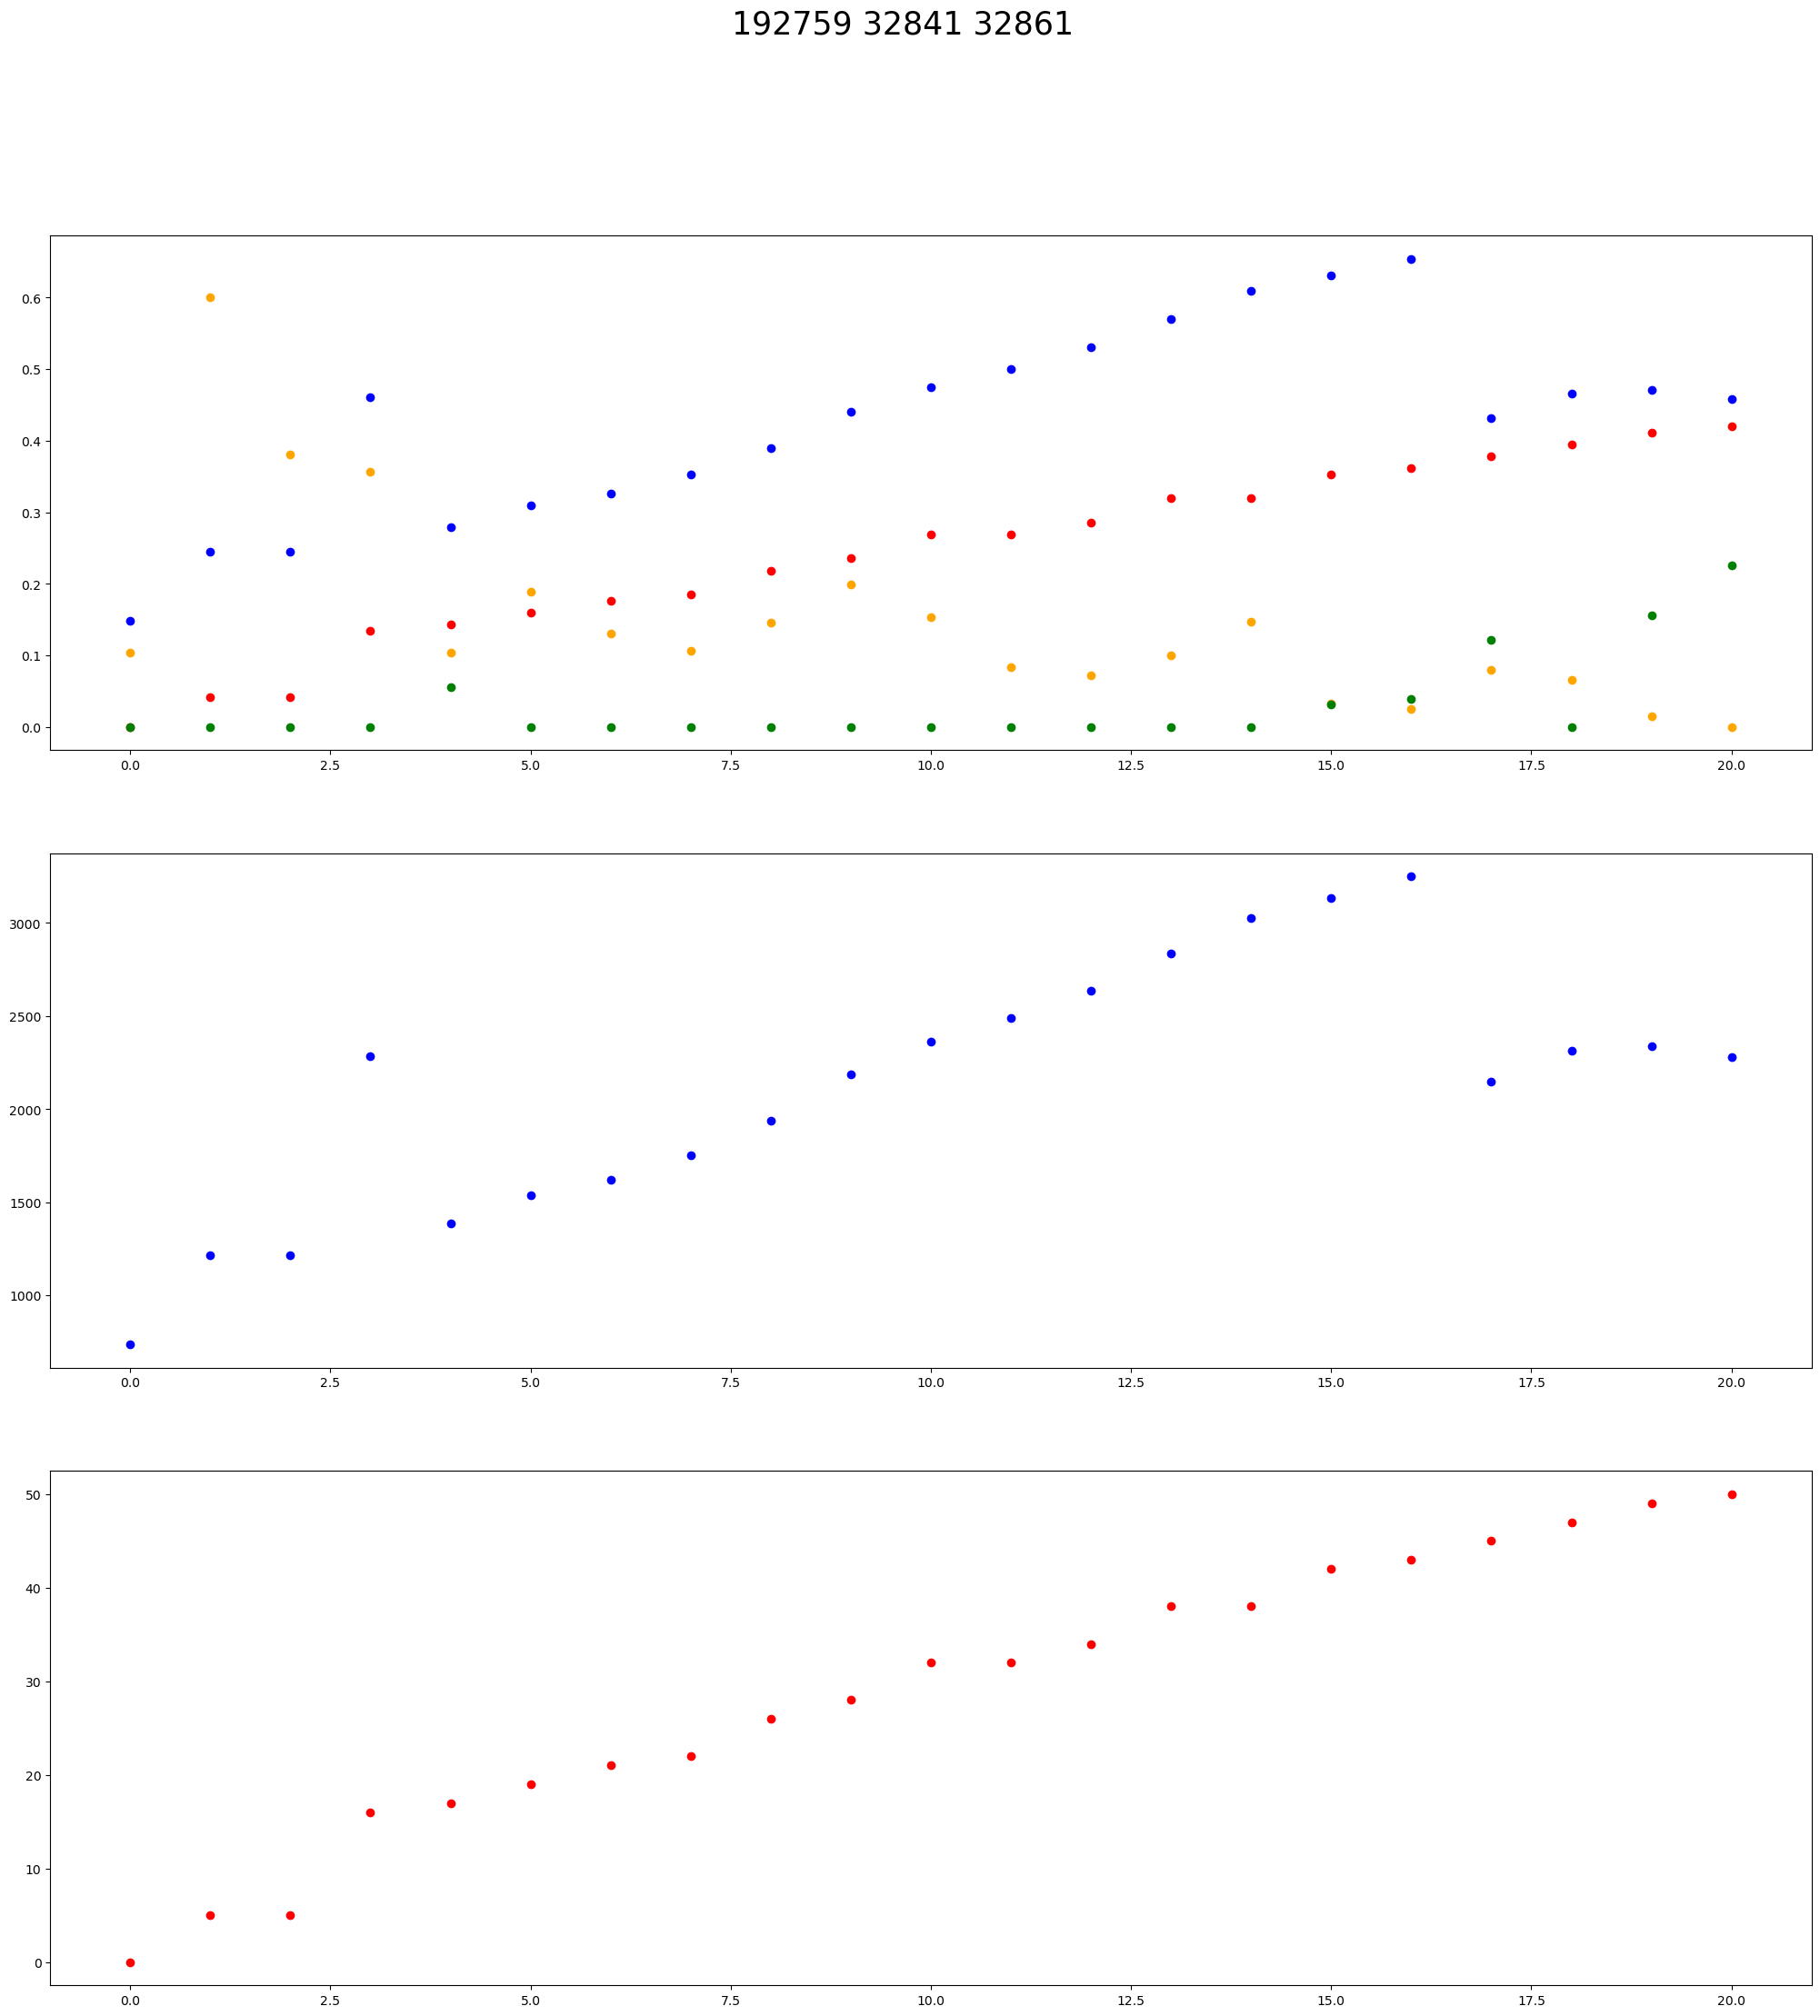

In [143]:
get_random_start_draw(subtracks=subtracksZtH, track_id=192759)

### Создание гистограмм

In [181]:
track_id_stop_list = [x
                      for x, y in Counter(df['trackid']).items()
                      if y == 5]

In [284]:
track_hist = {}

for track_id in df['trackid'].unique():

    if track_id in track_id_stop_list:
        continue

    data_hist = df[(df['trackid'] == track_id) &
                   (df['speed'] >= 30) &
                   (df['speed'] <= 50) &
                   (df['next5 speed'] - df['prev5 speed'] >= 5)]['diff_rpm']

    track_hist[track_id] = np.histogram(data_hist)

In [285]:
# get_random_start_draw(subtracks=subtracksZtH, track_id=188773) # 192493 191702 192759 | 190847 191794

### Кластеризация

In [251]:
X = np.array([track_hist[track_id][0]
              for track_id in sorted(track_hist.keys())])

X = pd.DataFrame(X)
for col in X.columns:
    X[col] = X[col] / X[col].max()

In [264]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)

In [265]:
track2label = {k: v for k, v in zip(sorted(track_hist.keys()), kmeans.labels_)}
label2tracks = defaultdict(list)
for k, v in track2label.items():
    label2tracks[v].append(k)

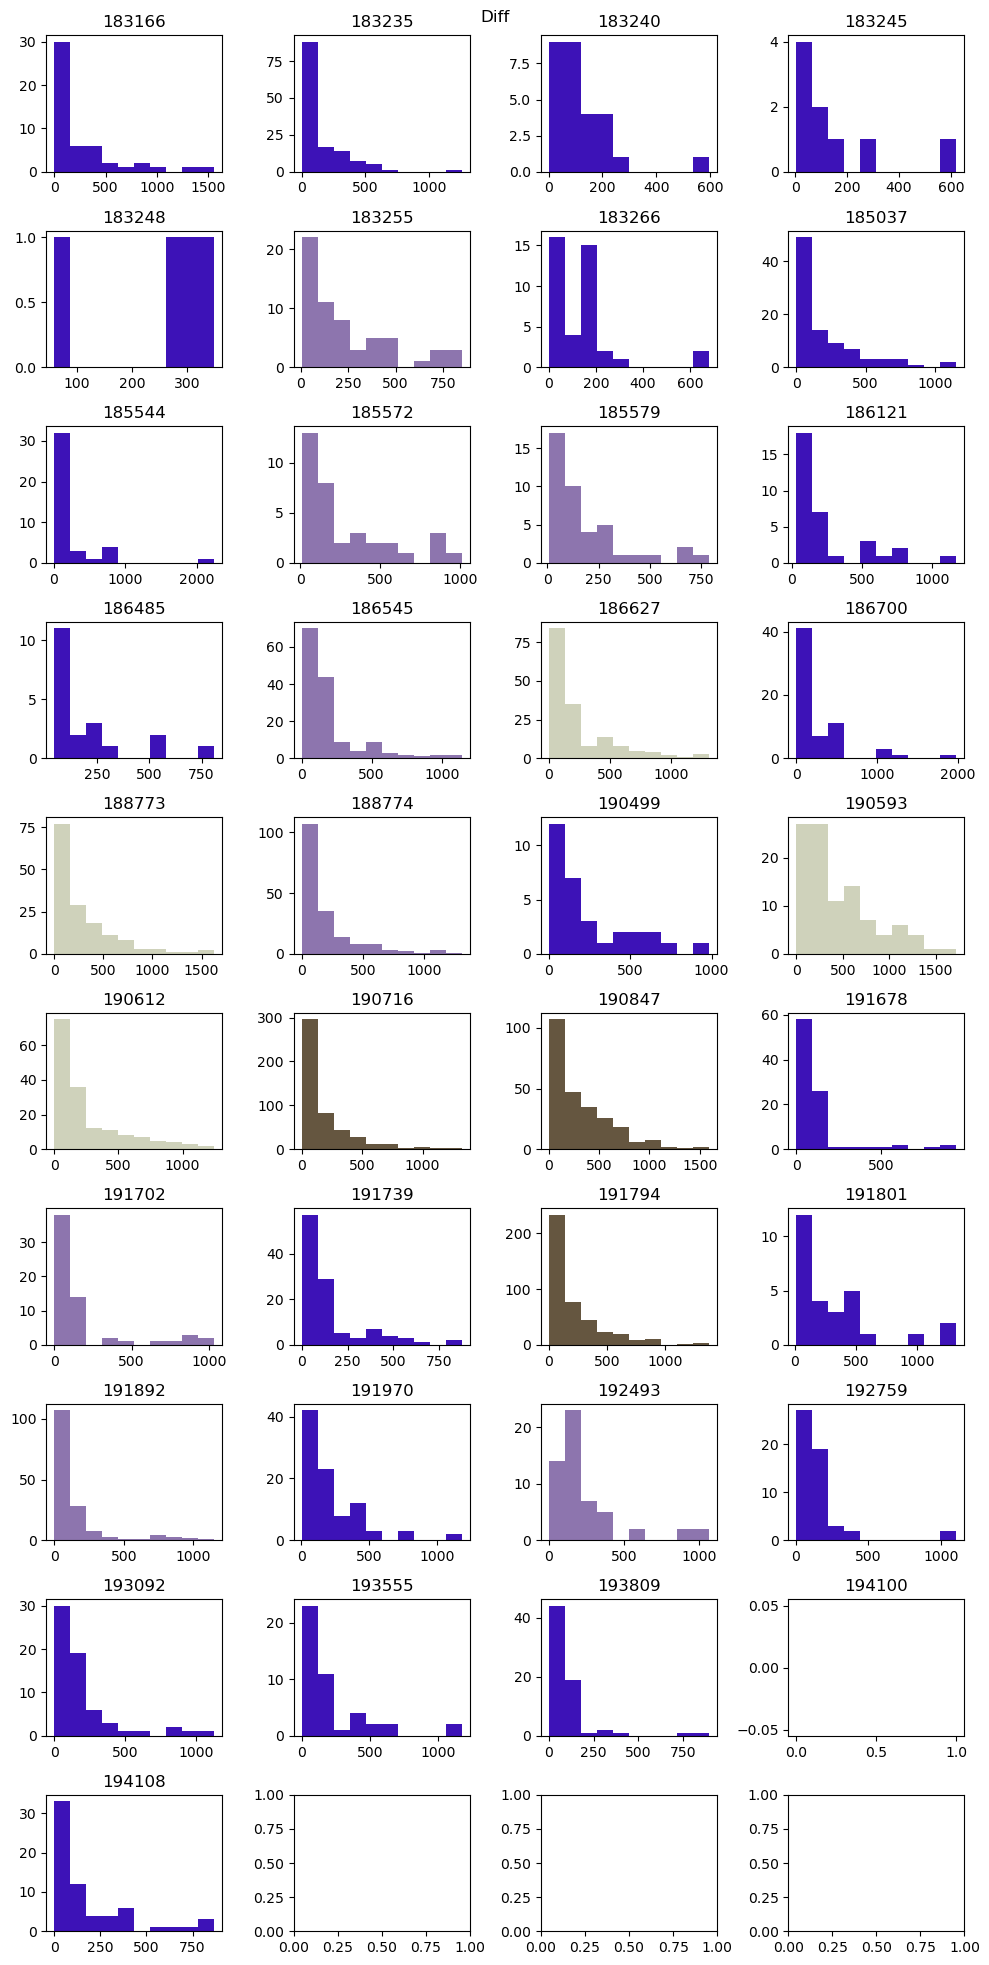

In [266]:
fig, axs = plt.subplots(10, 4, figsize=(10, 20))
fig.suptitle('Diff')
i_c = 0
j_c = 0

cluster2color = {cluster: (np.random.rand(), np.random.rand(), np.random.rand())
                 for cluster in label2tracks.keys()}

for track_id in df['trackid'].unique():

    if track_id in track_id_stop_list:
        continue

    data_hist = df[(df['trackid'] == track_id) &
                   (df['speed'] >= 30) &
                   (df['speed'] <= 50) &
                   (df['next5 speed'] - df['prev5 speed'] >= 5)]['diff_rpm']

    axs[i_c, j_c].hist(data_hist, color=cluster2color[track2label[track_id]])
    axs[i_c, j_c].set_title(track_id)
    j_c += 1
    if j_c >= 4:
        i_c += 1
        j_c = 0

fig.tight_layout()
plt.show()

In [278]:
label2tracks

defaultdict(list,
            {0: [183166,
              183235,
              183240,
              183245,
              183248,
              183266,
              185037,
              185544,
              186121,
              186485,
              186700,
              190499,
              191678,
              191739,
              191801,
              191970,
              192759,
              193092,
              193555,
              193809,
              194100,
              194108],
             3: [183255,
              185572,
              185579,
              186545,
              188774,
              191702,
              191892,
              192493],
             2: [186627, 188773, 190593, 190612],
             1: [190716, 190847, 191794]})

### Интерпретация
##### По графикам видно, что в кластерах 2 и 1 (темно-зеленый и бледно-желтый) значительно более равномерные распределения, исходя из чего я делаю вывод, что это заезды на автомобилях с вариатором (заезды 186627, 188773, 190593, 190612, 190716, 190847, 191794). А на графиках из кластеров 0 и 3 менее равномерные распределения с большим количеством выбросов на больших оборотах, что говорит о заездах на механике.

##### Этот подход можно доработать, улучшив фильтры по подгруппам заездов и кластеризацию, результаты можно использовать как грубую разметку для обучения модели для более точного и быстрого решения на больших данных.